In [4]:
import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

In [5]:
# Function to load dataset
def load_dataset(image_dir, img_size=(256, 256)):
    """Load images and labels from the specified directory."""
    images, labels = [], []
    for folder_name in os.listdir(image_dir):
        folder_path = os.path.join(image_dir, folder_name)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, img_size)
                    images.append(image)
                    labels.append(folder_name)
    return np.array(images), np.array(labels)

# Load dataset
image_dir = '../cowImages'
images, labels = load_dataset(image_dir)

Accuracy: 0.6326530612244898
Classification Report:
               precision    recall  f1-score   support

 healthycows       0.79      0.55      0.65       240
   lumpycows       0.52      0.77      0.62       152

    accuracy                           0.63       392
   macro avg       0.65      0.66      0.63       392
weighted avg       0.68      0.63      0.64       392



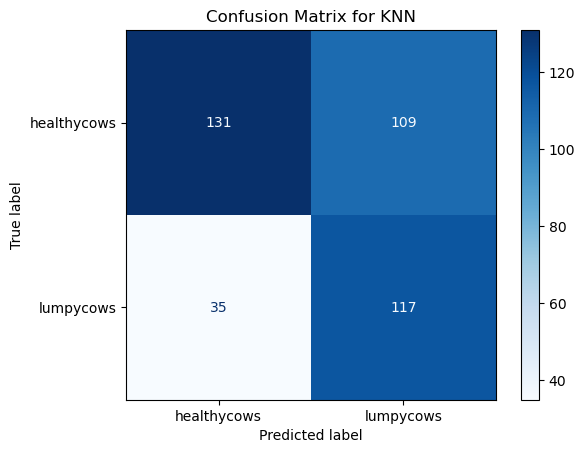

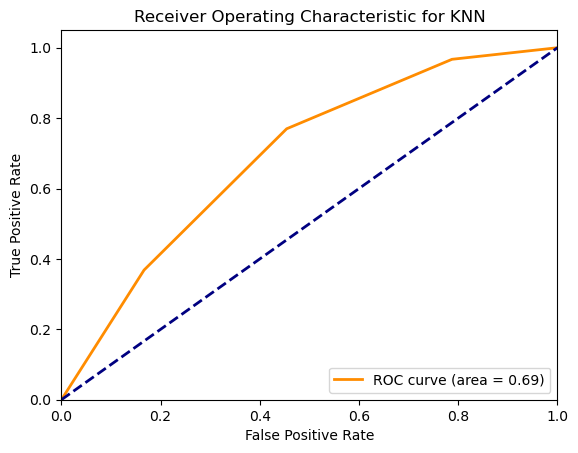

In [6]:
# Flatten and normalize the images
images_flattened = images.reshape(len(images), -1) / 255.0

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels_encoded, test_size=0.2, random_state=42)

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Save the trained model and label encoder for later use
with open('knn_model.pkl', 'wb') as model_file, open('label_encoder.pkl', 'wb') as encoder_file:
    pickle.dump(knn, model_file)
    pickle.dump(label_encoder, encoder_file)

# Calculate confusion matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=label_encoder.classes_)
disp_knn.plot(cmap='Blues')
plt.title("Confusion Matrix for KNN")
plt.show()

# Plot ROC curve
if len(label_encoder.classes_) == 2:  # Binary classification case
    y_pred_probabilities = knn.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_pred_probabilities)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
else:  # Multiclass case (handled differently)
    y_test_binarized = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
    y_pred_probabilities = knn.predict_proba(X_test)
    for i, class_label in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probabilities[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve of class {class_label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KNN')
plt.legend(loc="lower right")
plt.show()


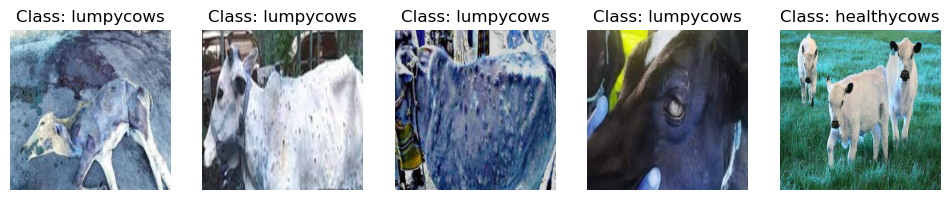

In [7]:
# Display sample images with annotations
def display_sample_images(images, labels, label_encoder, num_samples=5):
    plt.figure(figsize=(12, 12))
    indices = np.random.choice(range(len(images)), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Class: {label_encoder.inverse_transform([labels[idx]])[0]}")
        plt.axis('off')
    plt.show()

display_sample_images(images, labels_encoded, label_encoder)

In [14]:
# Function to predict LSD on a new image
def predict_lsd(image_path, model_path='knn_model.pkl', encoder_path='label_encoder.pkl', img_size=(256, 256)):
    """Predict whether a cow has Lumpy Skin Disease from an image."""
    # Load the model and label encoder
    with open(model_path, 'rb') as model_file, open(encoder_path, 'rb') as encoder_file:
        knn = pickle.load(model_file)
        label_encoder = pickle.load(encoder_file)
    
    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or could not be loaded.")
    
    image = cv2.resize(image, img_size)
    image_flattened = image.reshape(1, -1) / 255.0
    
    # Predict the label
    label_encoded = knn.predict(image_flattened)
    label = label_encoder.inverse_transform(label_encoded)
    
    
    # classify the label for better understanding.
    if label[0] == "lumpycows":
        return "Affected with Lumpy Skin Disease"
    else:
        return "Healthy"


# Example usage
new_image_path = '../cowimages/lumpycows/img1018.jpg'
prediction = predict_lsd(new_image_path)
print(f"The prediction for the image is: {prediction}")

The prediction for the image is: Affected with Lumpy Skin Disease
